### Importation des bibliothèques nécessaires

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Partie 1 : L’opérateur de seuillage doux

### Implémentation de soft_thresholding

In [ ]:

def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)


### Tracage de la fonction pour v ∈ [−5, 5]

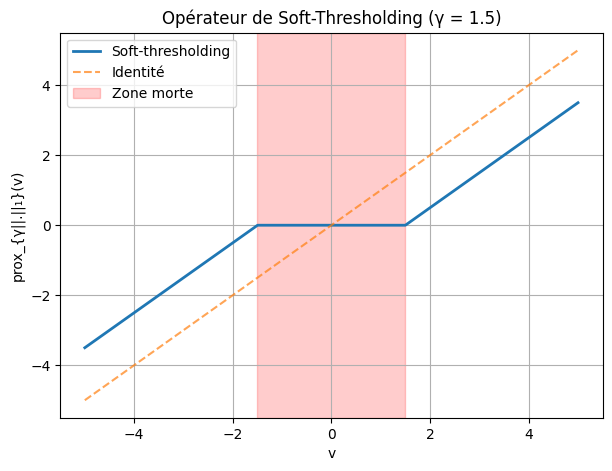

In [ ]:
# Paramètres
gamma = 1.5
v = np.linspace(-5, 5, 1000)

# Soft-thresholding
st = soft_thresholding(v, gamma)

# Tracé
plt.figure(figsize=(7, 5))
plt.plot(v, st, label="Soft-thresholding", linewidth=2)
plt.plot(v, v, '--', label="Identité", alpha=0.7)

# Zone morte
plt.axvspan(-gamma, gamma, alpha=0.2, color='red', label="Zone morte")

plt.xlabel("v")
plt.ylabel("prox_{γ||.||₁}(v)")
plt.title("Opérateur de Soft-Thresholding (γ = 1.5)")
plt.legend()
plt.grid(True)
plt.savefig("Opérateur de soft-Thresholding (y=1.5).png",dpi=300, bbox_inches="tight")
plt.show()

# Partie 2 : Implémentation de ISTA

### Génération d’un dataset synthétique

In [ ]:
np.random.seed(0)

# Dimensions
n = 100
d = 50
sparsity = 5  # nombre de variables réellement explicatives

# Matrice des données
X = np.random.randn(n, d)

# Vecteur w vrai (creux)
w_true = np.zeros(d)
indices_non_nuls = np.random.choice(d, sparsity, replace=False)
w_true[indices_non_nuls] = np.random.randn(sparsity)

# Bruit
noise = 0.1 * np.random.randn(n)

# Variable cible
y = X @ w_true + noise

### Calcul de la constante de Lipschitz

In [ ]:
# Calcul de lambda_max(X^T X)
XtX = X.T @ X
lambda_max = np.linalg.eigvalsh(XtX).max()

# Constante de Lipschitz
L = lambda_max / n

### Implémentation de ISTA

In [ ]:
# Fonction objectif
def lasso_objective(X, y, w, lam):
    n = X.shape[0]
    data_fit = 0.5 / n * np.linalg.norm(X @ w - y) ** 2
    reg = lam * np.linalg.norm(w, 1)
    return data_fit + reg


#Gradient de la partie lisse

def gradient_f(X, y, w):
    n = X.shape[0]
    return (1 / n) * X.T @ (X @ w - y)

# Algorithme ISTA
def ista(X, y, lam, L, n_iter=200):
    d = X.shape[1]
    w = np.zeros(d)
    obj_values = []

    for k in range(n_iter):
        grad = gradient_f(X, y, w)
        w = soft_thresholding(w - grad / L, lam / L)
        obj_values.append(lasso_objective(X, y, w, lam))

    return w, obj_values

### convergence

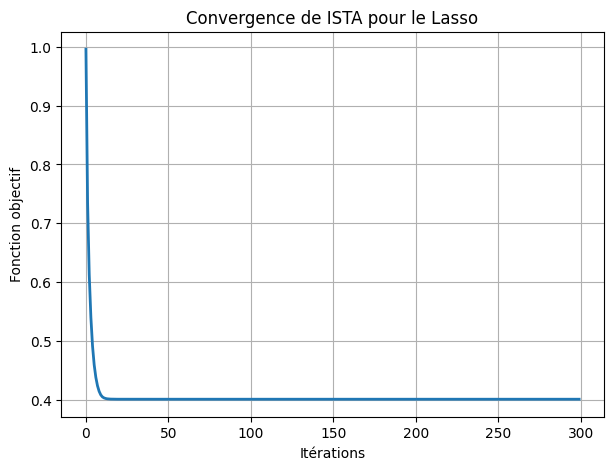

In [ ]:
# Paramètre de régularisation
lam = 0.1

# Lancement de ISTA
w_ista, obj_values = ista(X, y, lam, L, n_iter=300)

# Tracé de la fonction objectif
plt.figure(figsize=(7, 5))
plt.plot(obj_values, linewidth=2)
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.title("Convergence de ISTA pour le Lasso")
plt.grid(True)

plt.savefig("ista_convergence_lasso.png", dpi=300, bbox_inches="tight")
plt.show()

# Partie3:Analysedelaparcimonie(Sparsity)

In [ ]:
from sklearn.linear_model import Lasso

#Grille de valeurs de α
alphas = np.logspace(-4, 0, 30)  # de 10^-4 à 1

#Entraînement et comptage des zéros
n_zeros = []
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=5000)
    lasso.fit(X, y)

    w = lasso.coef_
    coefs.append(w)
    n_zeros.append(np.sum(w == 0))

### nombre de coefficients nuls

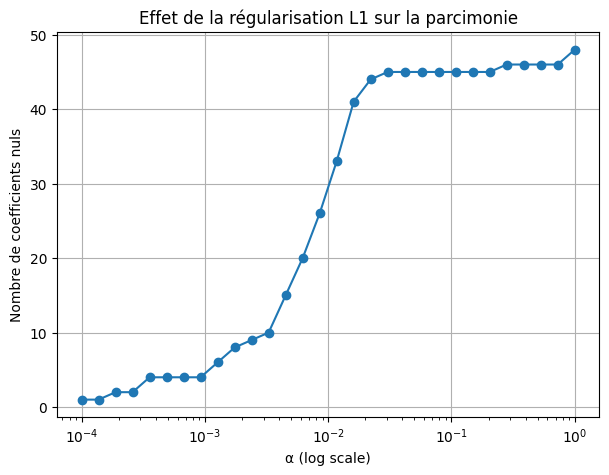

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(alphas, n_zeros, marker='o')
plt.xscale("log")
plt.xlabel("α (log scale)")
plt.ylabel("Nombre de coefficients nuls")
plt.title("Effet de la régularisation L1 sur la parcimonie")
plt.grid(True)

plt.savefig("sparsity_vs_alpha.png", dpi=300, bbox_inches="tight")
plt.show()


### Lasso Path

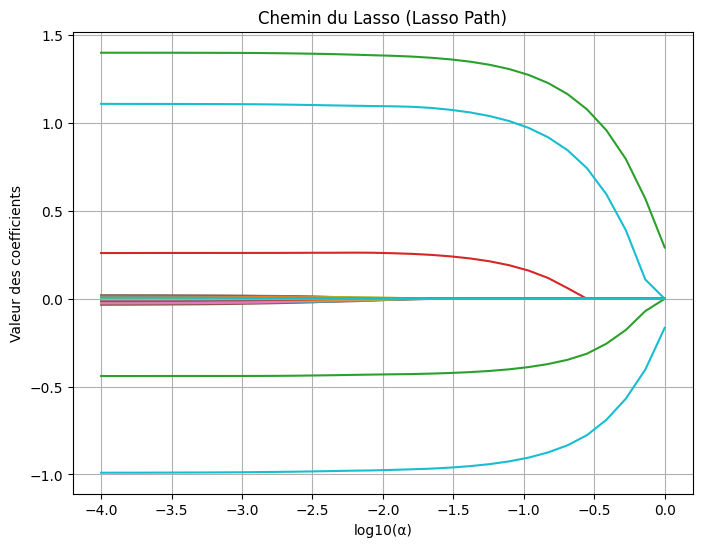

In [ ]:
coefs = np.array(coefs)

plt.figure(figsize=(8, 6))

for j in range(coefs.shape[1]):
    plt.plot(np.log10(alphas), coefs[:, j])

plt.xlabel("log10(α)")
plt.ylabel("Valeur des coefficients")
plt.title("Chemin du Lasso (Lasso Path)")
plt.grid(True)

plt.savefig("lasso_path.png", dpi=300, bbox_inches="tight")
plt.show()


# TP2 : Partie 1 : Sélection de caractéristiques (Breast Cancer)

### Importation nécessaires

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Chargement et standardisation
data = load_breast_cancer()
X = data.data
y = data.target
y = 2*y - 1  # convertir en {-1,1} pour la log-loss
feature_names = data.feature_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n, d = X_scaled.shape

In [ ]:
# Soft-thresholding
# ------------------------
def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)

# ------------------------
# Gradient de la log-loss
# ------------------------
def grad_logloss(w, X, y):
    z = y * (X @ w)
    sigma = 1 / (1 + np.exp(z))  # sigma(-y * Xw)
    grad = -(1/n) * (X.T @ (y * sigma))
    return grad

# ------------------------
# Fonction objectif (log-loss + L1)
# ------------------------
def logistic_lasso_objective(w, X, y, lam):
    z = y * (X @ w)
    logloss = np.mean(np.log(1 + np.exp(-z)))
    return logloss + lam * np.sum(np.abs(w))

# ------------------------
# ISTA pour la régression logistique Lasso
# ------------------------
def ista_logistic_lasso(X, y, lam, L, n_iter=500):
    w = np.zeros(X.shape[1])
    obj_values = []

    for _ in range(n_iter):
        grad = grad_logloss(w, X, y)
        w = soft_thresholding(w - grad/L, lam/L)
        obj_values.append(logistic_lasso_objective(w, X, y, lam))

    return w, obj_values

# ------------------------
# Test avec λ=0.5
# ------------------------
lam = 0.5
# Constante de Lipschitz du gradient (approx)
L = 0.25 * np.max(np.linalg.eigvals(X_scaled.T @ X_scaled)) / n

w_lasso, obj_values = ista_logistic_lasso(X_scaled, y, lam, L, n_iter=500)

# Variables sélectionnées
selected_idx = np.where(w_lasso != 0)[0]
print("Variables sélectionnées :", feature_names[selected_idx])
print("Coefficients :", w_lasso[selected_idx])

# Nombre de variables éliminées
n_zero = np.sum(w_lasso == 0)
print("Nombre de variables éliminées :", n_zero)

Variables sélectionnées : []
Coefficients : []
Nombre de variables éliminées : 30


## Visualisation du chemin des coefficients pour plusieurs λ

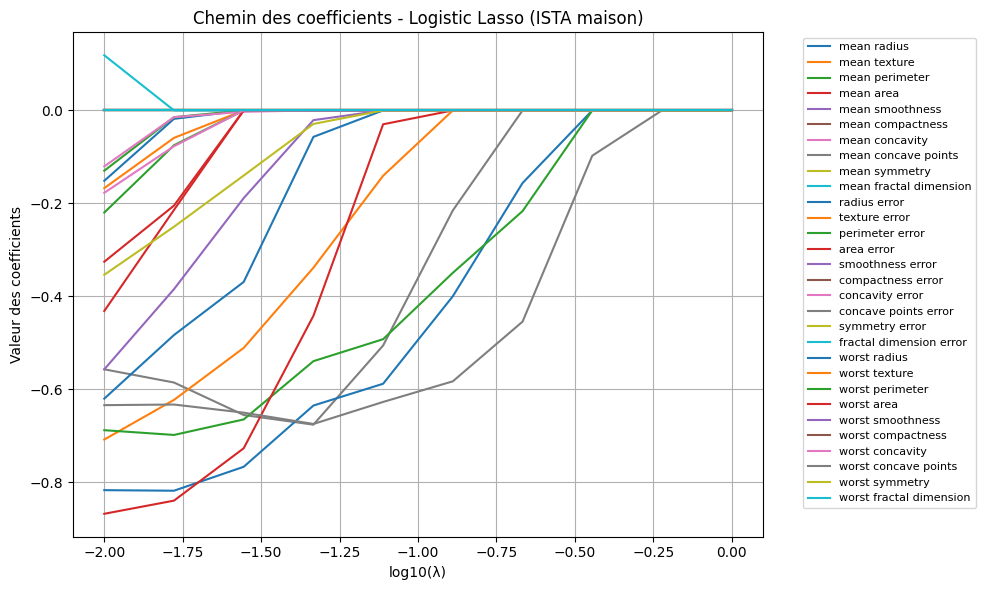

In [ ]:
lambdas = np.logspace(-2, 0, 10)  # de 0.01 à 1
coefs = []

for lam in lambdas:
    w_lasso, _ = ista_logistic_lasso(X_scaled, y, lam, L, n_iter=500)
    coefs.append(w_lasso)

coefs = np.array(coefs)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for j in range(d):
    plt.plot(np.log10(lambdas), coefs[:, j], label=feature_names[j])
plt.xlabel("log10(λ)")
plt.ylabel("Valeur des coefficients")
plt.title("Chemin des coefficients - Logistic Lasso (ISTA maison)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


##Partie2:DébruitageparISTA(DatasetOlivettiFaces)

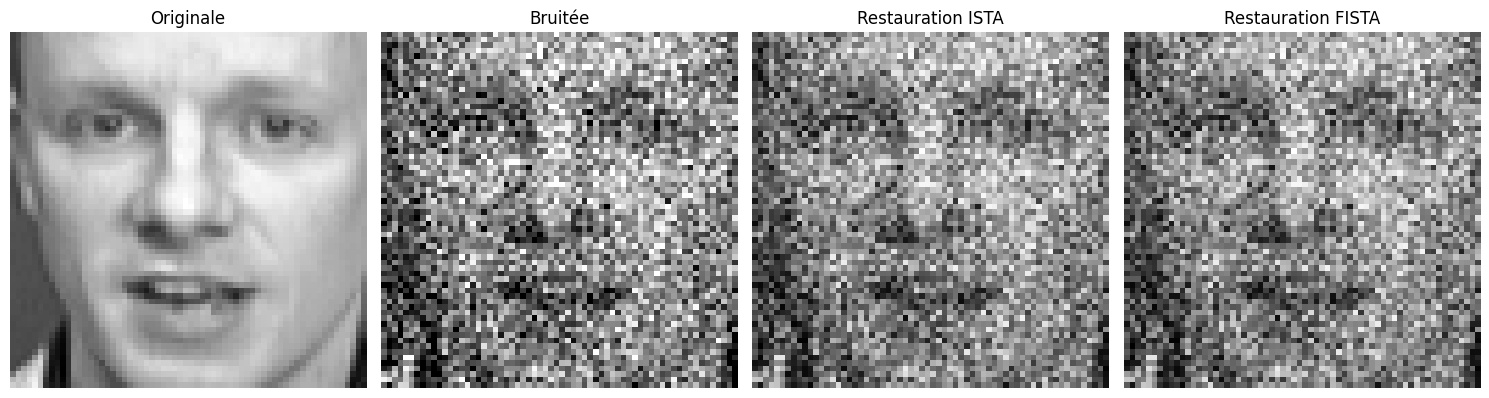

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from scipy.fftpack import dct, idct

# ------------------------
# 1. Chargement de l'image
# ------------------------
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
image = faces.images[0]        # image originale
y = image.flatten()

# Ajouter un bruit gaussien
np.random.seed(42)
sigma = 0.2
y_noisy = y + sigma * np.random.randn(*y.shape)
y_noisy = np.clip(y_noisy, 0, 1)  # garder valeurs entre 0 et 1

# ------------------------
# 2. Transformée DCT 2D
# ------------------------
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Convertir image en DCT
y_noisy_2d = y_noisy.reshape(image.shape)
y_dct = dct2(y_noisy_2d)

# ------------------------
# 3. Soft-thresholding
# ------------------------
def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)

# ------------------------
# 4. ISTA/FISTA sur DCT
# ------------------------
def ista_dct(y_dct, lam, n_iter=50):
    w = np.copy(y_dct)
    for _ in range(n_iter):
        grad = w - y_dct
        w = soft_thresholding(w - grad, lam)
    return w

def fista_dct(y_dct, lam, n_iter=50):
    w = np.copy(y_dct)
    z = np.copy(w)
    t = 1
    for _ in range(n_iter):
        w_old = np.copy(w)
        grad = z - y_dct
        w = soft_thresholding(z - grad, lam)
        t_new = (1 + np.sqrt(1 + 4*t**2))/2
        z = w + ((t - 1)/t_new)*(w - w_old)
        t = t_new
    return w

# ------------------------
# 5. Paramètres
# ------------------------
lam = 0.05  # seuil L1 sur DCT
n_iter_ista = 100
n_iter_fista = 50

# ------------------------
# 6. Débruitage
# ------------------------
restored_ista_dct = ista_dct(y_dct, lam, n_iter_ista)
restored_fista_dct = fista_dct(y_dct, lam, n_iter_fista)

# Retour dans l'espace image
w_ista = idct2(restored_ista_dct)
w_fista = idct2(restored_fista_dct)

# Clip final pour rester dans [0,1]
w_ista = np.clip(w_ista, 0, 1)
w_fista = np.clip(w_fista, 0, 1)

# ------------------------
# 7. Visualisation
# ------------------------
def plot_images(original, noisy, restored_ista, restored_fista):
    fig, axes = plt.subplots(1,4,figsize=(15,4))
    axes[0].imshow(original, cmap='gray'); axes[0].set_title("Originale"); axes[0].axis('off')
    axes[1].imshow(noisy.reshape(original.shape), cmap='gray'); axes[1].set_title("Bruitée"); axes[1].axis('off')
    axes[2].imshow(restored_ista, cmap='gray'); axes[2].set_title("Restauration ISTA"); axes[2].axis('off')
    axes[3].imshow(restored_fista, cmap='gray'); axes[3].set_title("Restauration FISTA"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(image, y_noisy, w_ista, w_fista)
